# Population firing rate
### 1. Overview

In recent experiments, people are able to manipulate *Dictyostelium*  population firing rate by changing two cell-cell coupling parameters- population density and extracellular fluid flow rate/ $cAMP_{e}$ dilution rate(Figure 7A). in a  In this notebook we are going to explore how different model tunes population firing rate with different densities and dilution rates  cells (Figure 7, below).

Because it is computationally costly to reproduce the full and high resolution heatmap for each model, this notebook offers two options for readers to play with different models.

1) Define a set of parameter pairs (density, dilution rate) of interest  and visualize simulation traces of population-wide dynamics. 

2) Reproduce a heat map with lower resolution. For example,define a parameter set with size 5 x 5 and visualize the heatmap. Note that the full simulation for a model could cost up to 2 hours on a 36-core computing node with parallel computing. Therefore it is not advised to use this notebook to run full, high resolution simulations. 
 
![Figure 7](pop_firing_rate_SCnoise.png)
<h5><center>Figure 7</center></h5>

#### Let's start by importing packages and setting up time scaling parameters

In [1]:
import numpy as np
from time import perf_counter 
from scipy.signal import find_peaks
import math

import matplotlib.pyplot as plt

import matplotlib
font = {'family' : 'Arial'}
matplotlib.rc('font', **font)

import scipy.io
import pandas as pd

from Goldbeter1987_agent_and_pop_FUN import Goldbeter1987_pop_3var_SCnoise
from MaedaLoomis2004_agent_and_pop_FUN import MaedaLoomis2004_pop_SCnoise
from Gregor2010_agent_and_pop_FUN import Gregor2010_pop
from Sgro2015_agent_and_pop_FUN import Sgro2015_pop
from Kamino2017_agent_and_pop_FUN import Kamino2017_pop_SCnoise

from NB_pop_functions import * 

# Normalization parameters
from NormParam import *

divcolors=np.array([[145, 35, 57], #Primary Red
        [35,  145, 40], #Primary Green
        [43, 159, 180], #Primary Cyan
        [104, 61, 101],#Primary Purple
        [91,  91,  91],#Primary Gray
        [255, 109, 123], #Secondary Pink
        [255, 149, 21], #Secondary Orange
        [127, 56, 17]])/255 #secondary Brown
greens=np.array([[122,255,11], #Lightest
        [2,  255, 45],
        [76, 222, 82], 
        [1, 178, 31],
        [35, 145,  40],
        [10, 68, 12]])/255 #Darkest
oranges=np.array([[255,162,111], #Lightest
        [255, 184 , 98],
        [255, 149, 21], 
        [231, 117, 78],
        [180, 50,  25],
        [178, 79, 24]])/255 #Darkest
blues=np.array([[112,233,255], #Lightest
        [69, 183 , 204],
        [52, 137, 153], 
        [43, 159, 180],
        [59, 34, 255],
        [42, 24, 178]])/255 #Darkest
pinks=np.array([[250,184,237], #Lightest
        [181, 124 ,177],
        [181, 88, 174], 
        [250, 59, 212],
        [104, 61, 101],
        [153, 36, 102]])/255 #Darkest

### 2. Experimental data 
#### import and plot experimental data
from [Sgro & Mehta 2015](https://www.embopress.org/doi/full/10.15252/msb.20145352)

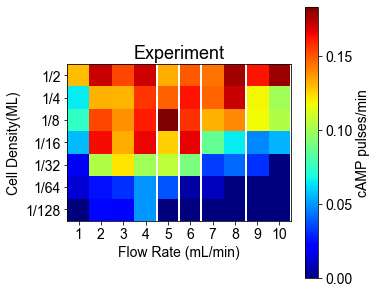

In [2]:
PopRateExp = np.array([[0.129660088,0.171190476,0.152777778,0.171016069,0.132986111,0.149074074,0.144444444,0.177170868,0.162719633,0.178571429],
[0.065434419,0.131937322,0.131658497,0.156811146,0.147619048,0.162799043,0.147368421,0.171820616,0.11875,0.1],
[0.075416667,0.152597403,0.138703704,0.161497326,0.183333333,0.157142857,0.132373581,0.139815266,0.117989418,0.103125],
[0.057236842,0.164138177,0.13287037,0.165909091,0.126666667,0.166827485,0.086222222,0.065789474,0.047584541,0.055555556],
[0.019047619,0.103693161,0.122423896,0.100198413,0.106683375,0.091592443,0.034122807,0.042105263,0.031818182,0],
[0.014285714,0.026428571,0.031578947,0.049938272,0.038095238,0.00625,0.010526316,0,0,0],
[0,0.02375,0.022222222,0.050595238,0,0,0,0,0,0]])

JExp = np.linspace(1,10, num=10) # np.array([0,1,2,4,6,8,10,15,16,20])
RhoExp = np.linspace(1,7, num=7) #  np.array([0.5,0.25,0.125,0.0625,0.03125,0.015625,0.0078125])

fig3 = plt.figure(figsize=(5, 5))
grid = plt.GridSpec(1,1, wspace=0.5, hspace=0.4)

ax0= fig3.add_subplot(grid[0,0])
ax0.set_xticks([0,1,2,3,4,5,6,7,8,9]); 
ax0.set_xticklabels([1,2,3,4,5,6,7,8,9,10],fontsize=14)
ax0.set_yticks([0,1,2,3,4,5,6,7]); 
ax0.set_yticklabels(['1/2','1/4','1/8','1/16','1/32','1/64','1/128'],fontsize=14)
ax0.set_title('Experiment', fontdict={'fontsize': 18, 'fontweight': 'medium'})
ax0.set_xlabel('Flow Rate (mL/min)', size=14)
ax0.set_ylabel('Cell Density(ML)', size=14)
heatmap = ax0.imshow(PopRateExp, cmap='jet') # cmap='jet'
x=[3.5,4.5,5.5,7.5,9.5]
[ax0.axvline(_x, color='white',linewidth=2) for _x in x]
# heatmap.set_clim(0,0.16)
cbar=fig3.colorbar(heatmap, ax=ax0,ticks=[0,0.05,0.1,0.15]);
cbar.ax.tick_params(labelsize = 14) 
cbar.set_label( 'cAMP pulses/min',size=14)

### 3. Matiel 1986
#### Set up parameters (from Table II in [Matiel & Goldbeter 1986](https://www.sciencedirect.com/science/article/pii/S0006349587832757?via%3Dihub) )

In [3]:
k1 = 0.036     # per min
k2 = 0.666    # per min
L1 = 10; L2 = 0.005 
c = 10;           # 0.15 ~ 50
lamda = 0.01; theta = 0.01; e =  1 ; q = 4000; sig= 0.6
v = 12; k = 4 # k prime in the paper
ki = 1.7; kt = 0.9; 
kc = 5.4 # extracellular cAMP degradation/dilution rate
h = 5 # proportional to 1/density

sigma = 10 # noise strength
N = 100 # number of cells

Goldbeter3PopParam={'k1':k1,'k2':k2,'L1':L1,'L2':L2, 'c':c, 'lamda':lamda,\
            'theta':theta, 'e':e, 'q':q,'sig':sig, 'v':v, 'k':k, \
            'ki':ki,'kt':kt, 'kc':kc,'h':h, 'sigma':sigma, 'N':N}
dt=0.001; t_tot=30; t=list(np.arange(0,t_tot*Nt_Goldbeter,dt))
nSteps = len(t)

#### Define population density and dilution/flow rate, and get population $cAMP_i$ simulation response

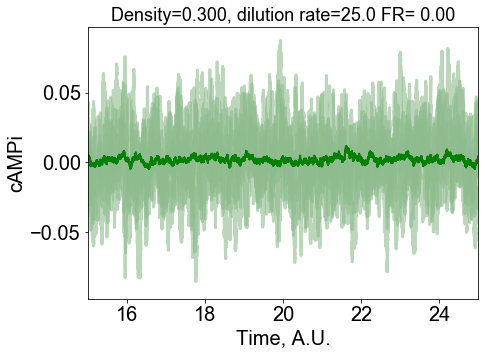

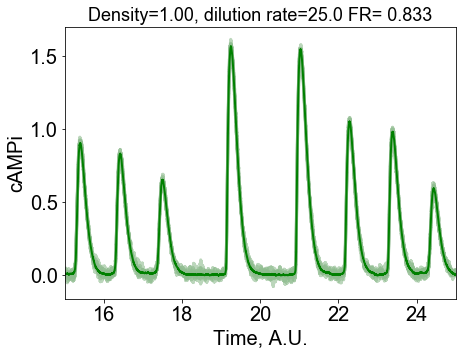

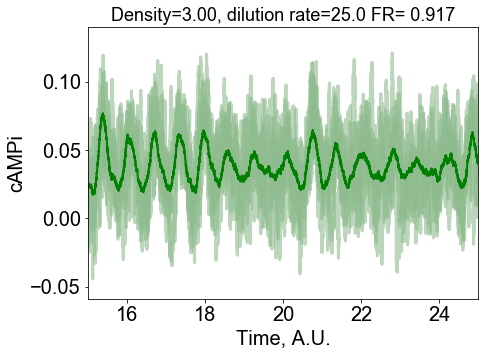

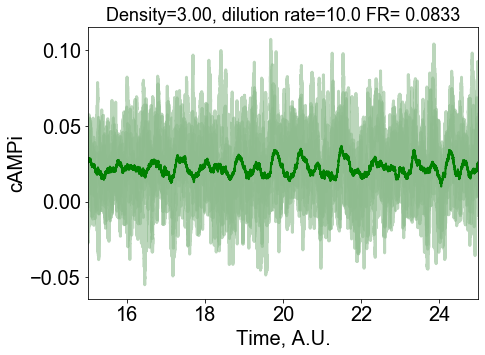

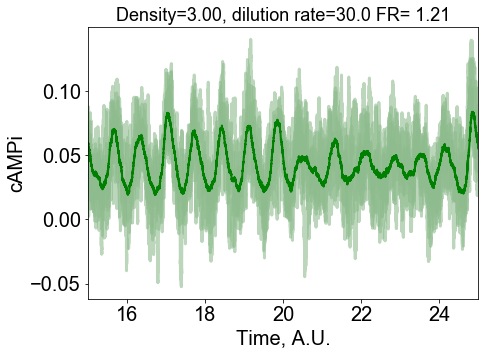

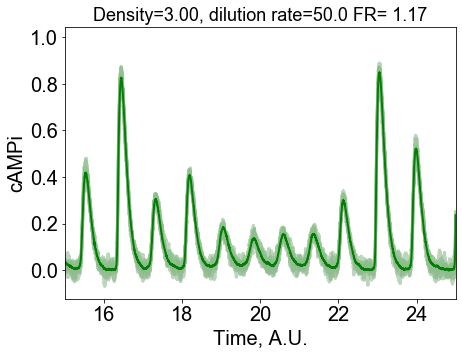

In [4]:
t_plot_Goldbeter = np.array(t)/Nt_Goldbeter
later_portion = 0.2 # start count peaks after this X total simulation time
t_plot_Goldbeter_short = t_plot_Goldbeter[math.floor(nSteps * later_portion):] 
    
# cAMPe influx level. Default as 0. 
campExt_influx_trace=np.zeros(len(t))
cAMPext_influx = 0; cAMPext_influx_trace = np.ones(nSteps)*cAMPext_influx

# Define dilution/flow rate array
kc_arr = np.array([25,25,25,
                   10,30,50]) # ([25])
# Define population density array
one_over_h_arr = np.array([0.3,1,3,
                           3,3,3]) # ([0.3,1,3])# cell density 
h_arr = 1/one_over_h_arr 
# empty arrays
FR_gold = np.zeros((len(kc_arr),1))
b_traces_later = np.zeros((len(kc_arr), N, len(t_plot_Goldbeter_short)))
b_traces_mean_later = np.zeros((len(kc_arr),len(t_plot_Goldbeter_short)))

if_plt_traces = True # whether to plot individuial traces

for temp in range(len(kc_arr)):
    Goldbeter3PopParam['kc'] = kc_arr[temp]
    Goldbeter3PopParam['h'] =  h_arr[temp]
    # Initializations
    p0=0.8*np.ones(N); a0=3; b0=0.9*np.ones(N); g0=0
    p_trace=np.zeros((N,nSteps));p_trace[:,0] = p0; 
    b_trace=np.zeros((N,nSteps));b_trace[:,0] = b0; 
    g_trace=np.zeros((nSteps,1));g_trace[0] = g0; 

    Goldbeter3_pop= Goldbeter1987_pop_3var_SCnoise(0,p0,b0,g0,Goldbeter3PopParam)

    for i in range(len(t)-1):
        p_next,b_next,g_next= Goldbeter3_pop.update(dt,a0,cAMPext_influx_trace[i]) # cAMPext_influx_trace[i])
        p_trace[:,i+1]= p_next
        b_trace[:,i+1]= b_next
        g_trace[i+1] = g_next
    # normalize
    b_trace_norm = b_trace/Nh_Goldbeter
    b_trace_norm_mean = np.mean(b_trace_norm,axis = 0)

    b_trace_norm_later = b_trace_norm[:,math.floor(nSteps * later_portion):]
    b_trace_norm_mean_later=b_trace_norm_mean[math.floor(nSteps * later_portion):] # the later part of trace
    g_trace_later = g_trace[math.floor(nSteps * later_portion):]
    
    b_traces_mean_later[temp,:] = b_trace_norm_mean_later
    b_traces_later[temp,:,:] = b_trace_norm_later
    
    pk_find_thresh = 5/Nh_Goldbeter
    # pk_find_prm = 0.1
    # pop_max = np.amax(b_trace_norm_mean); pop_min = np.amin(b_trace_norm_mean); 
    # PkPos, PkProperties = find_peaks(b_trace_norm_mean_later, prominence = pk_find_prm*(pop_max-pop_min))
    PkPos, PkProperties = find_peaks(b_trace_norm_mean_later, prominence = pk_find_thresh)

    if len(PkPos) == 0:
        firing_rate = 0;
    else:   
        firing_rate = len(PkPos)/(t_tot*(1-later_portion))
    FR_gold[temp] = firing_rate 
    
    if if_plt_traces:  
        title = 'Density='+'{:#.3n}'.format(np.float64(1/h_arr[temp]))+\
            ', dilution rate='+ '{:#.3n}'.format(np.float64(kc_arr[temp]))+' FR= '+'{:#.3n}'.format(np.float64(firing_rate)) 
        SC_traces_idx = [0,2,4,6,8,10]
        plot_POP_oscillation_FR(title, t_plot_Goldbeter_short,b_traces_mean_later[temp,:],'cAMPi',
                        0,0,0,[15,25],b_traces_later[temp,:,:], SC_traces_idx )    

        # out_dir = 'C:/Users/ellin/Dropbox/AACP Science/Dicty model review drafts/figures/pop_FR_out/'
        # plot_name = 'Gold_0416_noise'+str(sigma)+'_density'+'{:#.3n}'.format(np.float64(1/h_arr[temp]))+\
        #     '_j'+ '{:#.3n}'.format(np.float64(kc_arr[temp]))+'_FR'+'{:#.3n}'.format(np.float64(firing_rate))
        # plt.savefig(out_dir + plot_name + '.eps', format='eps')
        # plt.savefig(out_dir + plot_name + '.png', format='png')
        # plt.show()
            
np.savez('pop_FR_supp_200426.npz',
         t_plot_Goldbeter_short = t_plot_Goldbeter_short ,
         b_traces_mean_later = b_traces_mean_later,
         b_traces_later = b_traces_later,
         FR_gold = FR_gold)

         
         

#### plot population mean and selected single cell traces

### 4. Maeda 2004
#### Set up parameters (from supplementary in [Maeda et al 2004](https://science.sciencemag.org/content/304/5672/875/tab-figures-data) )

In [5]:
k1=2.0; k2=0.9; k3=2.5; k4=1.5; k5=0.6
k6=0.8; k7=1.0; k8=1.3; k9=0.3; k10=0.8
k11=0.7; k12=4.9; k13=23; k14=4.5

sigma = 0.1 # noise strength
N = 100  # number of cells

MaedaPopParam={'k1':k1,'k2':k2,'k3':k3,'k4':k4,'k5':k5,'k6':k6,\
            'k7':k7,'k8':k8,'k9':k9,'k10':k10,'k11':k11,'k12':k12,\
            'k13':k13,'k14':k14, 'N':N, 'sigma':sigma}
dt=0.001; t_tot=60; t=list(np.arange(0,t_tot*Nt_Maeda,dt))
nSteps = len(t)

#### Define population density and dilution/flow rate, and get population $cAMP_i$ simulation response

"\n        out_dir = 'C:/Users/ellin/Dropbox/AACP Science/Dicty model review drafts/figures/pop_FR_out/'\n        plot_name = 'Maeda_0416_noise'+str(sigma)+'_density'+'{:#.3n}'.format(np.float64(rho_arr_Maeda[temp]))+            '_j'+ '{:#.3n}'.format(np.float64(gamma_temp))+'_FR'+'{:#.3n}'.format(np.float64(firing_rate))\n        plt.savefig(out_dir + plot_name + '.eps', format='eps')\n        plt.savefig(out_dir + plot_name + '.png', format='png')\n        plt.show()\n        "

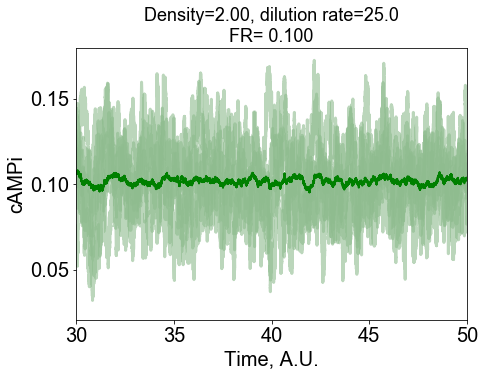

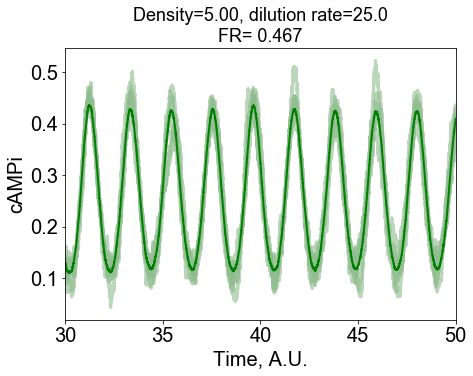

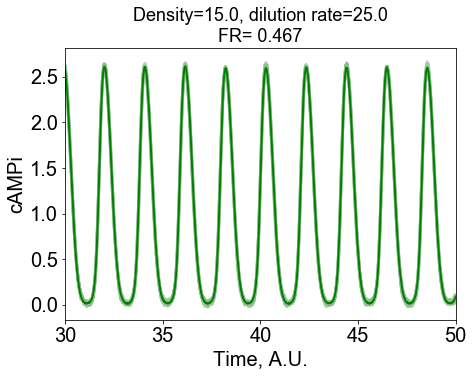

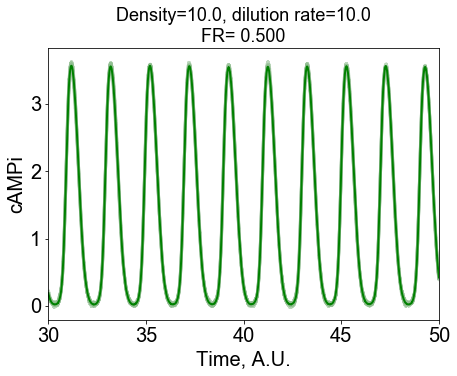

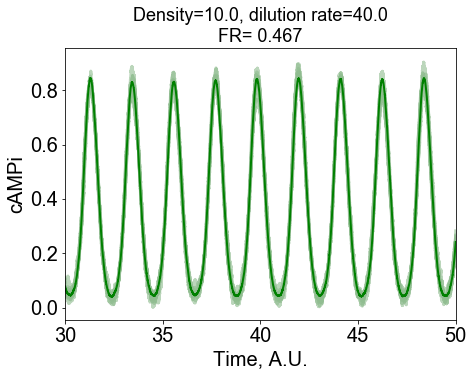

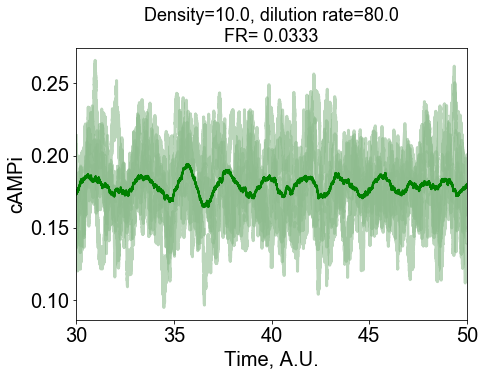

In [6]:
t_plot_Maeda = np.array(t)/Nt_Maeda
later_portion = 0.5 # start count peaks after this X total simulation time
t_plot_Maeda_short = t_plot_Maeda[math.floor(nSteps * later_portion):] 
    
# cAMPe influx level. Default as 0. 
cAMPext_influx_trace=np.zeros(len(t))
cAMPext_influx = 0; cAMPext_influx_trace = np.ones(nSteps)*cAMPext_influx

# Define dilution/flow rate array
gamma_arr_Maeda = np.array([25,25,25,10,40,80]) # ([25])# 
# Define population density array
rho_arr_Maeda = np.array([2,5,15,10,10,10])# ([2,5,50]) #

# empty arrays
FR_Maeda = np.zeros((len(kc_arr),1))
cAMPi_traces_later = np.zeros((len(gamma_arr_Maeda), N, len(t_plot_Maeda_short)))
cAMPi_traces_mean_later = np.zeros((len(gamma_arr_Maeda),len(t_plot_Maeda_short)))

if_plt_traces = True # whether to plot individuial traces

for temp in range(len(gamma_arr_Maeda)):
    gamma_temp = gamma_arr_Maeda[temp]; rho_temp = rho_arr_Maeda[temp]
    # Initializations
    ACA0=0.1*np.ones(N); PKA0=0.1*np.ones(N); ERK20=0.1*np.ones(N); 
    RegA0=0.1*np.ones(N); cAMPi0=0.01*np.ones(N); cAMPe0=0.1; CAR10=0.1*np.ones(N)

    ACA_trace=np.zeros((N,nSteps)); ACA_trace[:,0] = ACA0
    PKA_trace=np.zeros((N,nSteps)); PKA_trace[:,0] = PKA0
    ERK2_trace=np.zeros((N,nSteps)); ERK2_trace[:,0] = ERK20
    RegA_trace= np.zeros((N,nSteps)); RegA_trace[:,0] = RegA0
    cAMPi_trace= np.zeros((N,nSteps)); cAMPi_trace[:,0] = cAMPi0
    cAMPe_trace=np.zeros((nSteps,1));cAMPe_trace[0] = cAMPe0;
    CAR1_trace= np.zeros((N,nSteps)); CAR1_trace[:,0] = CAR10

    MaedaLoomis_pop=MaedaLoomis2004_pop_SCnoise([1,1],ACA0,PKA0,ERK20,RegA0,cAMPi0,cAMPe0,CAR10, MaedaPopParam)

    for i in range(len(t)-1):
        ACA_next,PKA_next,ERK2_next,RegA_next,\
        cAMPi_next,cAMPe_next,CAR1_next=MaedaLoomis_pop.update(dt,cAMPext_influx_trace[i],rho_temp,gamma_temp)
        ACA_trace[:,i+1]= ACA_next
        PKA_trace[:,i+1]= PKA_next
        ERK2_trace[:,i+1]= ERK2_next
        RegA_trace[:,i+1]= RegA_next
        cAMPi_trace[:,i+1]= cAMPi_next
        cAMPe_trace[i+1]= cAMPe_next
        CAR1_trace[:,i+1]= CAR1_next


    cAMPi_trace_norm = cAMPi_trace/Nh_Maeda   
    cAMPi_trace_norm_mean = np.mean(cAMPi_trace_norm,axis = 0) # population mean

    cAMPi_trace_norm_later = cAMPi_trace_norm[:,math.floor(nSteps * later_portion):]
    cAMPi_trace_norm_mean_later=cAMPi_trace_norm_mean[math.floor(nSteps * later_portion):] # the later part of trace
    cAMPe_trace_later = cAMPe_trace[math.floor(nSteps * (1-later_portion)):] 
    
    cAMPi_traces_later[temp,:,:] = cAMPi_trace_norm_later
    cAMPi_traces_mean_later [temp,:] = cAMPi_trace_norm_mean_later

    pop_max = np.amax(cAMPi_trace_norm_mean_later); pop_min = np.amin(cAMPi_trace_norm_mean_later); 
    pk_find_prm = 0.7
    PkPos, PkProperties = find_peaks(cAMPi_trace_norm_mean_later, prominence=((pop_max-pop_min)*pk_find_prm,pop_max))

    if len(PkPos) == 0:
        firing_rate = 0; height = 0
    else: 
        firing_rate = len(PkPos)/(t_tot*(1-later_portion))
        height = np.mean(PkProperties["prominences"])
    FR_Maeda[temp] = firing_rate
    if if_plt_traces:    
        title = 'Density='+'{:#.3n}'.format(np.float64(rho_arr_Maeda[temp]))+\
            ', dilution rate='+ '{:#.3n}'.format(np.float64(gamma_arr_Maeda[temp]))+\
        '\nFR= '+'{:#.3n}'.format(np.float64(FR_Maeda[temp])) 
        plot_POP_oscillation_FR(title, t_plot_Maeda_short,cAMPi_trace_norm_mean_later,'cAMPi',
                        0,0,0,[30,50],  cAMPi_trace_norm_later, SC_traces_idx )  
'''
        out_dir = 'C:/Users/ellin/Dropbox/AACP Science/Dicty model review drafts/figures/pop_FR_out/'
        plot_name = 'Maeda_0416_noise'+str(sigma)+'_density'+'{:#.3n}'.format(np.float64(rho_arr_Maeda[temp]))+\
            '_j'+ '{:#.3n}'.format(np.float64(gamma_temp))+'_FR'+'{:#.3n}'.format(np.float64(firing_rate))
        plt.savefig(out_dir + plot_name + '.eps', format='eps')
        plt.savefig(out_dir + plot_name + '.png', format='png')
        plt.show()
        '''

        # plot population mean and selected single cell traces

        # plot_POP_oscillation(t_plot_Maeda_short,cAMPi_trace_norm_mean_later,cAMPext_influx,
        #                      t_tot*(1-later_portion), 0,title, cAMPi_trace_norm_later, SC_traces_idx)


        


### 5. Gregor 2010 
#### Set up parameters

In [7]:
Amax=20;  Abas=0.4 # uM
w=2*math.pi/6 # min-1
Vc=1.1e-9 # ml
St=1.33 # cm2
Sc=1.3e-6 # cm2
K=0.0004 # uM, 400 pM
c_sec= 3.6 # min-1
c_excite=1.01 # min-1
Vt = 1 #chamber size ml

rho = 1/12 # density, what percentage of a monolayer
k = 5 # flow rate, ml/min

Nc=100 # Num of cells
eta = 0.002 # noise strength

GregorPopParam={'Amax':Amax,'Abas':Abas,'w':w,'Vc':Vc,'St':St,'Sc':Sc,'K':K,\
                'c_sec':c_sec,'c_excite':c_excite,'eta':eta, \
                'Nc':Nc, 'rho':rho, 'Vt':Vt,'k':k}
dt=0.001; t_tot=25; t=list(np.arange(0,t_tot*Nt_Gregor,dt))
nSteps = len(t)

#### Define population density and dilution/flow rate, and get population $cAMP_i$ simulation response

"\n        out_dir = 'C:/Users/ellin/Dropbox/AACP Science/Dicty model review drafts/figures/pop_FR_out/'\n        plot_name = 'Gregor_0420_noise'+str(eta)+'_density'+'{:#.3n}'.format(np.float64(rho_temp))+            '_j'+ '{:#.3n}'.format(np.float64(k_temp))+'_FR'+'{:#.3n}'.format(np.float64(firing_rate))\n        plt.savefig(out_dir + plot_name + '.eps', format='eps')\n        plt.savefig(out_dir + plot_name + '.png', format='png')\n        plt.show()\n"

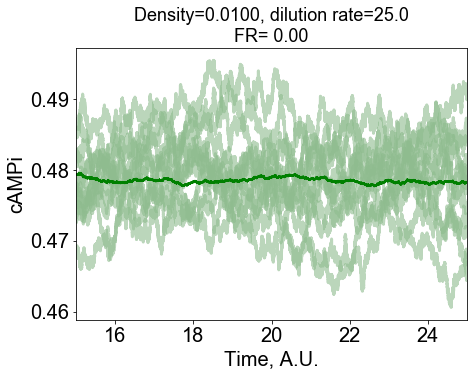

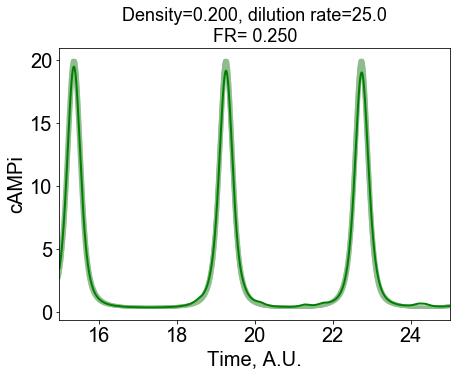

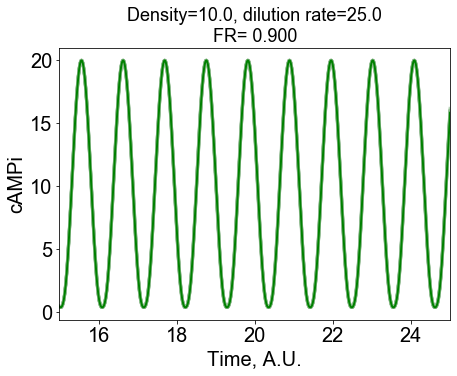

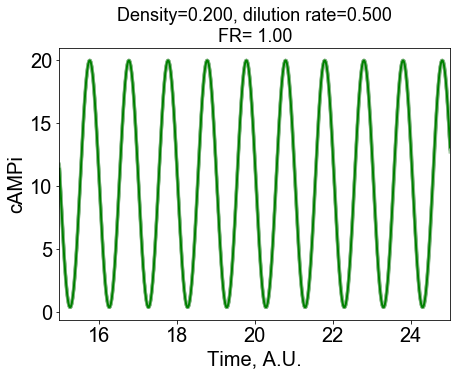

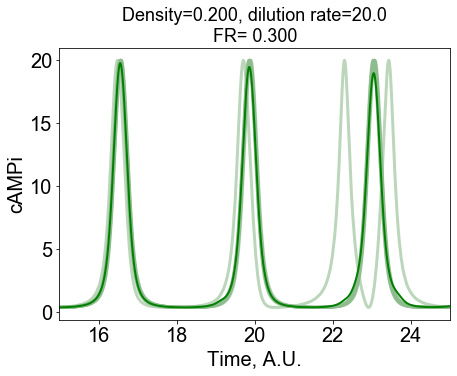

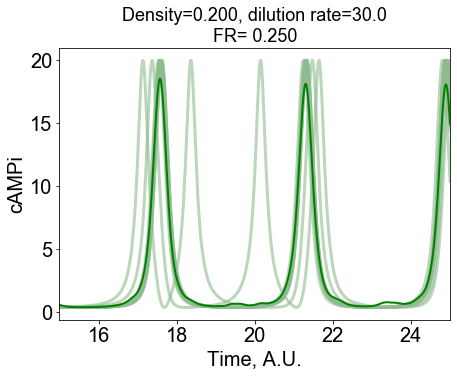

In [8]:
later_portion = 0.2 # start count peaks after this X total simulation time
t_plot_Gregor = np.array(t)/(Nt_Gregor)
t_plot_Gregor_later = t_plot_Gregor[math.floor(nSteps * later_portion):]
       
# cAMPe influx level. By default is 0.
cAMPext_influx_trace=np.zeros(len(t))
time_separation = 0

# Define dilution/flow rate array
k_arr_Gregor=np.array([25,25,25,
                      0.5,20,30]) # ([0.5,30,60]) # 
# Define population density array
rho_arr_Gregor =np.array([0.01,0.2,10,
                          0.2,0.2,0.2]) # ([0.2])# 

# empty arrays
FR_Gregor = np.zeros((len(k_arr_Gregor),1))
cAMPi_Gregor_later = np.zeros((len(k_arr_Gregor), N, len(t_plot_Gregor_later)))
cAMPi_Gregor_mean_later = np.zeros((len(k_arr_Gregor),len(t_plot_Gregor_later)))

if_plt_traces = True # whether to plot individuial traces
SC_traces_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12] # Index of single cell traces to plot 

for temp in range(len(k_arr_Gregor)):
    GregorPopParam['k'] = k_arr_Gregor[temp]
    GregorPopParam['rho'] = rho_arr_Gregor[temp]
    [t_plot_Gregor,  cAMPi, thetai,cAMPe] = Gregor_pop(GregorPopParam,dt,
                                                       t, cAMPext_influx_trace, time_separation)

    cAMPi_mean= np.mean(cAMPi,axis = 0)
    thetai_mean = np.mean(thetai,axis = 0)

    cAMPi_later = cAMPi[:,math.floor(nSteps * later_portion):] 
    cAMPi_mean_later = cAMPi_mean[math.floor(nSteps * later_portion):] 
    cAMPi_Gregor_later[temp,:,:] = cAMPi_later 
    cAMPi_Gregor_mean_later[temp,:] = cAMPi_mean_later

    # thetai_mean_later=thetai_mean[math.floor(nSteps * later_portion):] 
    # thetai_mean_later_norm = thetai_mean_later/np.amax(thetai_mean_later)

    cAMPe_later=cAMPe[math.floor(nSteps * later_portion):] 

    pk_find_thresh = 0.5
    PkPos, PkProperties = find_peaks(cAMPi_mean_later, prominence = pk_find_thresh)
    if len(PkPos) == 0:
        firing_rate = 0; height = 0
    else: 
        firing_rate = len(PkPos)/(t_tot*(1-later_portion))
        height = np.mean(PkProperties["prominences"])
    FR_Gregor[temp] = firing_rate

    if if_plt_traces:
        title = 'Density='+'{:#.3n}'.format(np.float64(rho_arr_Gregor[temp]))+\
            ', dilution rate='+ '{:#.3n}'.format(np.float64(k_arr_Gregor[temp]))+\
        '\nFR= '+'{:#.3n}'.format(np.float64(firing_rate))
        plot_POP_oscillation_FR(title, t_plot_Gregor_later, cAMPi_mean_later,'cAMPi',
                        0,0,0,[15,25], cAMPi_later, SC_traces_idx )  
'''
        out_dir = 'C:/Users/ellin/Dropbox/AACP Science/Dicty model review drafts/figures/pop_FR_out/'
        plot_name = 'Gregor_0420_noise'+str(eta)+'_density'+'{:#.3n}'.format(np.float64(rho_temp))+\
            '_j'+ '{:#.3n}'.format(np.float64(k_temp))+'_FR'+'{:#.3n}'.format(np.float64(firing_rate))
        plt.savefig(out_dir + plot_name + '.eps', format='eps')
        plt.savefig(out_dir + plot_name + '.png', format='png')
        plt.show()
'''

In [9]:
np.savez('pop_FR_supp_200426.npz',
         kc_arr = kc_arr, h_arr = h_arr,
         t_plot_Goldbeter_short = t_plot_Goldbeter_short ,
         b_traces_mean_later = b_traces_mean_later,
         b_traces_later = b_traces_later,
         FR_gold = FR_gold,
         gamma_arr_Maeda = gamma_arr_Maeda,rho_arr_Maeda = rho_arr_Maeda,
         t_plot_Maeda_short = t_plot_Maeda_short,
         cAMPi_traces_mean_later = cAMPi_traces_mean_later,
         cAMPi_traces_later = cAMPi_traces_later,
         FR_Maeda = FR_Maeda,
         k_arr_Gregor = k_arr_Gregor, rho_arr_Gregor = rho_arr_Gregor,
         t_plot_Gregor_later  = t_plot_Gregor_later ,
         cAMPi_Gregor_mean_later = cAMPi_Gregor_mean_later,
         cAMPi_Gregor_later = cAMPi_Gregor_later,
         FR_Gregor = FR_Gregor)

### 6. Sgro 2015 
#### Set up parameters
from [Sgro & Mehta 2015](https://www.embopress.org/doi/full/10.15252/msb.20145352)

In [10]:
e=0.1 # excitability
tauA=0.09; tauR=tauA/e; g=0.5

N = 100 # number of cells in the population
sigma = 0.15 # noise strength

j = 0.5 # extracellular cAMP dilution rate
rho = 10**(-3.5) # cell density

SgroPopParam={'e':e,'tauA':tauA,'tauR':tauR,'g':g,'c0':1.2,'sigma':sigma,'N':N,\
            'a':0.058,'alpha0':800,'alpha_pde':1000,'Kd':1e-5,'S':1e6,\
            'Nt':27,'Na':3.5,'offset_A':1.5,'flux_thrs':0, 'rho': rho,'j': j}

dt=0.001 ; t_tot=25*Nt_Sgro;t=list(np.arange(0,t_tot,dt))
nSteps = len(t)

#### Define population density and dilution/flow rate, and get population $cAMP_i$ simulation response

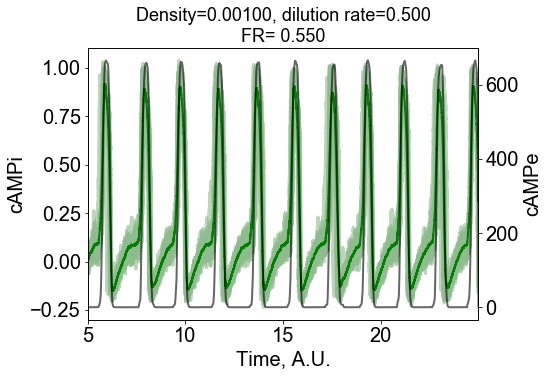

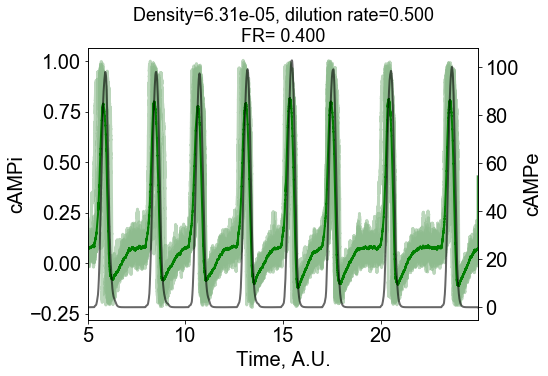

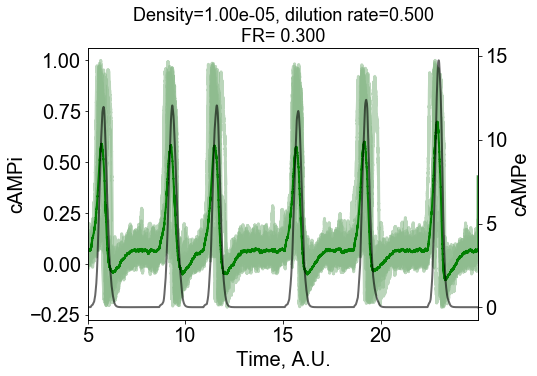

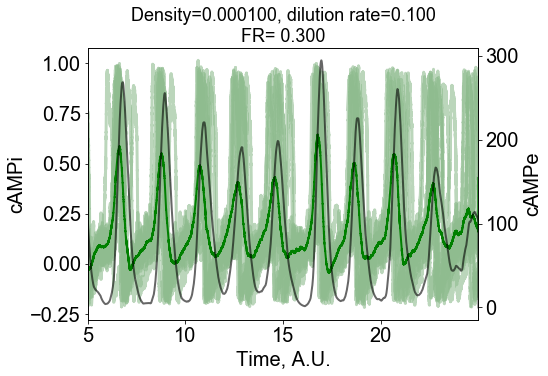

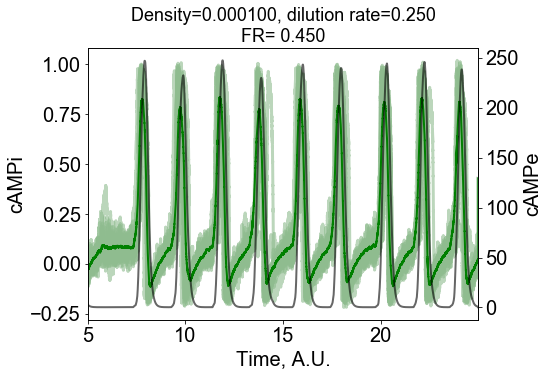

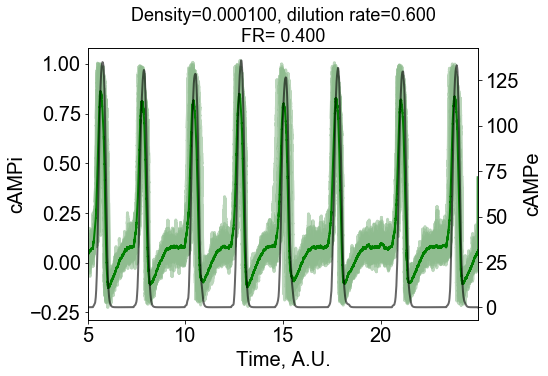

In [11]:
later_portion = 0.2 # start count peaks after this X total simulation time
t_plot_Sgro = np.array(t)/(Nt_Sgro)
t_plot_Sgro_later = t_plot_Sgro[math.floor(nSteps * later_portion):]
              
# cAMPe influx level. By default is 0.
cAMPext_influx_trace=np.zeros(len(t))

# Define dilution/flow rate array
j_arr_Sgro = np.array([0.5,0.5,0.5,
               0.1,0.25,0.6]) 
# Define population density array
rho_arr_Sgro =np.array([10**(-3),10**(-4.2),10**(-5),
                 10**(-4),10**(-4),10**(-4)])

# empty arrays
FR_Sgro = np.zeros((len(j_arr_Sgro),1))
A_traces_later = np.zeros((len(j_arr_Sgro), N, len(t_plot_Sgro_later)))
A_traces_mean_later = np.zeros((len(j_arr_Sgro),len(t_plot_Sgro_later)))

if_plt_traces = True # whether to plot individuial traces
SC_traces_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12] # Index of single cell traces to plot 

for temp in range(len(j_arr_Sgro)):
    SgroPopParam['j'] = j_arr_Sgro[temp]
    SgroPopParam['rho'] = rho_arr_Sgro[temp]
    [t_plot_Sgro, A_plot,  R_orig, R_plot, cAMPe] = Sgro_pop(SgroPopParam,dt,
                                                          t,cAMPext_influx_trace)

    A_plot_mean= np.mean(A_plot,axis = 0)
    R_plot_mean = np.mean(R_plot,axis = 0)
    A_plot_later = A_plot[:,math.floor(nSteps * later_portion):] 
    A_plot_mean_later=A_plot_mean[math.floor(nSteps * later_portion):] 

    A_traces_mean_later[temp,:] =A_plot_mean_later
    A_traces_later[temp,:,:] = A_plot_later 
    # R_plot_mean_later=R_plot_mean[math.floor(nSteps * later_portion):] 
    # R_plot_mean_later_norm = R_plot_mean_later/np.amax(R_plot_mean_later)
    cAMPe_later=cAMPe[math.floor(nSteps * later_portion):] 

    pk_find_thresh = 0.4
    PkPos, PkProperties = find_peaks(A_plot_mean_later, prominence = pk_find_thresh )
    if len(PkPos) == 0:
        firing_rate = 0; height = 0
    else: 
        firing_rate = len(PkPos)/(t_tot/Nt_Sgro*(1-later_portion))
        height = np.mean(PkProperties["prominences"])
    FR_Sgro[temp] = firing_rate
    if if_plt_traces:  
        title =  'Density='+'{:#.3n}'.format(np.float64(rho_arr_Sgro[temp]))+\
            ', dilution rate='+ '{:#.3n}'.format(np.float64(j_arr_Sgro[temp]))+\
        '\nFR= '+'{:#.3n}'.format(np.float64(firing_rate)) 

        ##  check find peaks
        # fig = plt.figure()
        # plt.plot(A_plot_mean_later)
        # plt.plot(PkPos, A_plot_mean_later[PkPos], "x")
        # plt.title(title)

        # Plot selected traces
        plot_POP_oscillation_FR(title, t_plot_Sgro_later,
                                A_plot_mean_later,'cAMPi',
                                0,0, cAMPe_later,[t_plot_Sgro_later[0],t_plot_Sgro_later[-1]],
                                A_plot_later, SC_traces_idx )  

### 7. Kamino 2017
#### Set up parameters

In [12]:
tau=1.5; n=2; K=4; kt=2; delta=0.01

gamma=3 # cAMPe dilution/degradation rate 
rho= 1 # population density

sigma = 0.01 # noise strength
N=100 # number of cells in a population

KaminoPopParam={'tau':tau,'n':n,'K':K,'kt':kt,'delta':delta,\
               'gamma':gamma,'rho':rho, 'sigma':sigma, 'N':N }
dt=0.001; t_tot = 50; t=list(np.arange(0,t_tot*Nt_Kamino,dt))
nSteps = len(t)

#### Define population density and dilution/flow rate, and get population $cAMP_i$ simulation response

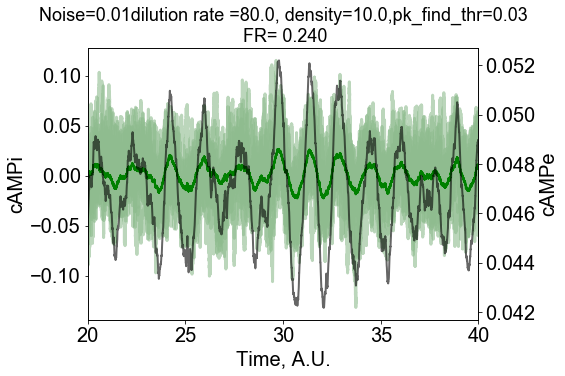

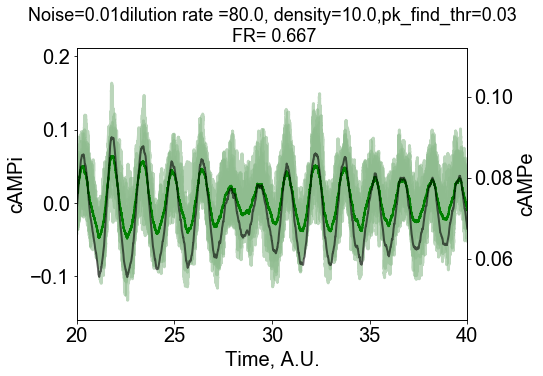

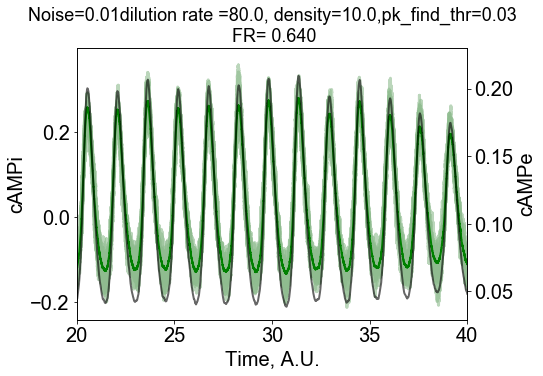

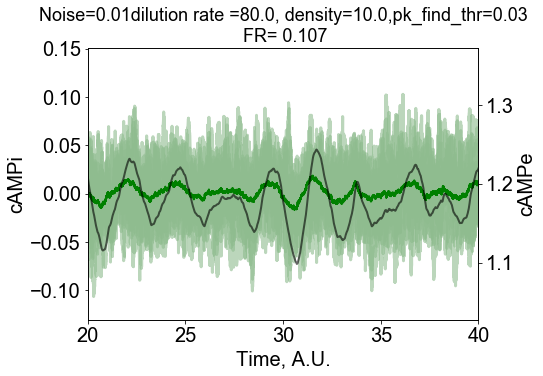

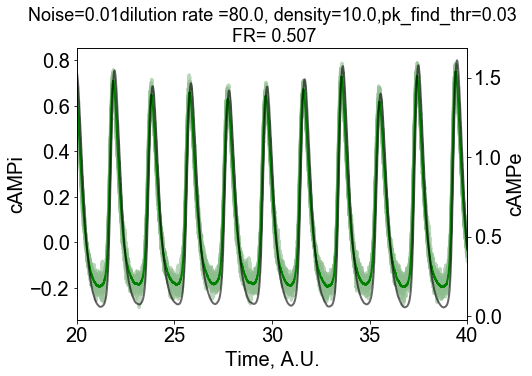

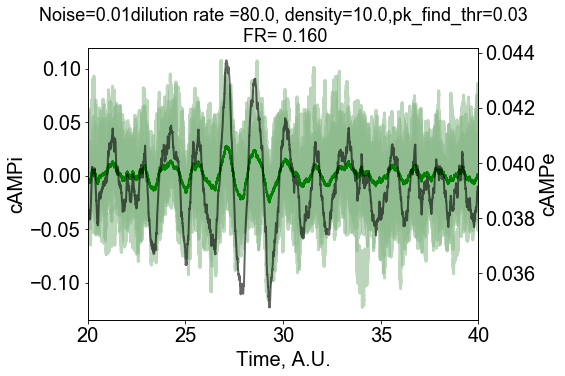

In [13]:
later_portion = 0.25 # start count peaks after this X total simulation time
t_plot_Kamino = np.array(t)/Nt_Kamino
t_plot_Kamino_short = t_plot_Kamino[math.floor(nSteps * later_portion):] 
    
# cAMPe influx level. Default is 0. 
cAMPext_influx_trace=np.zeros(len(t))

gamma_arr_Kamino = np.array([25,25,25,
                             1,3, 30])# ([25]) # 
rho_arr_Kamino = np.array([10,15,20,10,10, 10]) # np.array([20,15,10]) # ([10])

# empty arrays
FR_Kamino = np.zeros((len(gamma_arr_Kamino),1))
y_traces_later = np.zeros((len(gamma_arr_Kamino), N, len(t_plot_Kamino_short)))
y_traces_mean_later = np.zeros((len(gamma_arr_Kamino),len(t_plot_Kamino_short)))

if_plt_traces = True # whether to plot individuial traces

SC_traces_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12] # Index of single cell traces to plot 

for temp in range(len(gamma_arr_Kamino)):
    KaminoPopParam['gamma'] = gamma_arr_Kamino[temp]
    KaminoPopParam['rho'] = rho_arr_Kamino[temp]
    # Initializations
    x0=0.01*np.ones(N)
    y0=0.08*np.ones(N)
    z0=0
    x_trace=np.zeros((N,nSteps)); x_trace[:,0] = x0
    y_trace=np.zeros((N,nSteps)); y_trace[:,0] = y0
    z_trace=np.zeros((nSteps,1)); z_trace[0] = z0
    Kamino_pop = Kamino2017_pop_SCnoise(x0,y0,z0,KaminoPopParam)

    for i in range(nSteps-1):
        x_next,y_next,z_next=Kamino_pop.update(cAMPext_influx_trace[i],dt)
        x_trace[:,i+1] = x_next
        y_trace[:,i+1] = y_next
        z_trace[i+1] = z_next

    y_trace_norm =  (y_trace-Nh_Kamino_offset)/Nh_Kamino # height normalization
    y_trace_norm_later=y_trace_norm[:,math.floor(nSteps * later_portion):] # the later part of trace
    y_trace_norm_mean = np.mean(y_trace_norm,axis=0)
    y_trace_norm_mean_later=y_trace_norm_mean[math.floor(nSteps * later_portion):] # the later part of trace

    y_traces_mean_later[temp,:] = y_trace_norm_mean_later
    y_traces_later[temp,:,:] = y_trace_norm_later
    z_trace_later = z_trace[math.floor(nSteps * later_portion):]

    pk_find_thresh = 0.03
    PkPos, PkProperties = find_peaks(y_trace_norm_mean_later, prominence=pk_find_thresh)
    if len(PkPos) == 0:
        firing_rate = 0; height = 0
    else: 
        firing_rate = len(PkPos)/(t_tot*(1-later_portion))
        height = np.mean(PkProperties["prominences"])
    FR_Kamino[temp] = firing_rate
    
    if if_plt_traces:
        title = 'Noise=' +str(sigma)+ 'dilution rate ='+\
        '{:#.3n}'.format(np.float64(gamma_temp))+\
        ', density='+'{:#.3n}'.format(np.float64(rho_temp))+\
        ',pk_find_thr='+str(pk_find_thresh)+\
        '\n FR= '+'{:#.3n}'.format(np.float64(firing_rate))

        ## check find peaks
        # fig = plt.figure()
       #  plt.plot(y_trace_norm_mean_later)
        # plt.plot(PkPos, y_trace_norm_mean_later[PkPos], "x")
       #  plt.title(title)

        # Plot selected traces
        plot_POP_oscillation_FR(title, t_plot_Kamino_short,
                                y_trace_norm_mean_later,'cAMPi',
                                0,0, z_trace_later,[20,40],
                                y_trace_norm_later, SC_traces_idx )  
            

           
            


In [14]:
np.savez('pop_FR_supp_200426_cont.npz',
         j_arr_Sgro  = j_arr_Sgro , rho_arr_Sgro =rho_arr_Sgro ,
         t_plot_Sgro_later = t_plot_Sgro_later,
         A_traces_mean_later = A_traces_mean_later,
         A_traces_later = A_traces_later,
         FR_Sgro = FR_Sgro,
         gamma_arr_Kamino = gamma_arr_Kamino ,rho_arr_Kamino = rho_arr_Kamino,
         t_plot_Kamino_short = t_plot_Kamino_short,
         y_traces_mean_later = y_traces_mean_later,
         y_traces_later = y_traces_later,
         FR_Kamino = FR_Kamino)